In [1]:
from copy import copy
from itertools import combinations
import sys

import cv2
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np

def implt(img, cmp=None, t=''):
    """Show image using plt."""
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

Using TensorFlow backend.


In [2]:
clean_data_filename = "data/clean_data/test.h5"
model_filename = "model/bd_net/checkpoint_generator.h5"

In [9]:
def data_preprocess(x_data):
    return x_data/255


def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    
    x_data = data_preprocess(x_data)
    return x_data, y_data


def load_selection():
    x_test, y_test = data_loader(clean_data_filename)
    bd_model = keras.models.load_model(model_filename)
    
    # Plot mode
#     keras.utils.plot_model(bd_model, to_file='model.png')
    
    x_selected = []
    y_selected = []
    count = 7
    is_used = [False for _ in range(2000)]
    for i in range(len(x_test)):
        if not is_used[y_test[i]]:
            pred_y = np.argmax(
                bd_model.predict(np.expand_dims(x_test[i], axis=0))[0], axis=1)
            if y_test[i] == pred_y[0]:
                count -= 1
                is_used[y_test[i]] = True
                x_selected.append(x_test[i])
                y_selected.append(y_test[i])
                
        if count <= 0:
            break
            
    x_selected = np.array(x_selected)
    y_selected = np.array(y_selected)

    return bd_model, x_selected, y_selected


bd_model, x_data, y_data = load_selection()
print(x_data.shape)
print(y_data.shape)

(7, 55, 47, 3)
(7,)


In [10]:
class MaskPixel(object):
    def __init__(self, position, color):
        self.pos = position
        self.is_set = color[0]
        self.color = color[1]
        
    def set_val(self, pixel):
        self.pos = pixel.pos
        self.is_set = pixel.is_set
        self.color = pixel.color
        
    def update(self, position, color, mask, alpha_mask):
        alpha_mask[self.pos[0]][self.pos[1]] = 0
        mask[self.pos[0]][self.pos[1]] = (0, 0, 0)

        self.pos = position
        self.is_set = color[0]
        self.color = color[1]
        self.draw_mask(mask, alpha_mask)
        
    def draw_mask(self, mask, alpha_mask):
        if self.is_set:
            alpha_mask[self.pos[0]][self.pos[1]] = 1
        mask[self.pos[0]][self.pos[1]] = self.color

    
def add_mask(org, mask, alpha):
    fg = cv2.multiply(alpha, mask)
    bg = cv2.multiply(1.0 - alpha, org)
    return cv2.add(fg, bg)
    

def calc_avg_dist(model, x, mask, alpha):
    new_x = x.copy()
    for i in range(len(x)):
        new_x[i] = add_mask(new_x[i], mask, alpha)
    pred = model.predict(new_x)[0]
    summ = sum(sum(abs(z - y) for z, y in combinations(pred, 2)))
    return summ / (len(x) * (len(x) - 1) / 2)


def full_eval(model, mask, alpha):
    x_test, y_test = data_loader(clean_data_filename)

    for i in range(len(x_test)):
        x_test[i] = add_mask(x_test[i], mask, alpha)
    
    clean_label_p = np.argmax(bd_model.predict(x_test)[0], axis=1)
    probabl_bd_label = np.bincount(clean_label_p).argmax()
    y = np.array([probabl_bd_label] * len(x_test))
    
    class_accu = np.mean(np.equal(clean_label_p, y))
    print('Backdoor accuracy:', class_accu)
    print(clean_label_p)

2.000000036582653
2.0000000215007114
2.0000000182838553
2.0000000027078118
1.9999999841559795
1.9999999728681122
1.9999999556351218
1.9999999094343048
(0, 26) (1, 1, 1)
1.9999999094343048


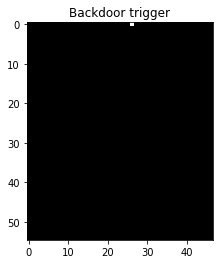

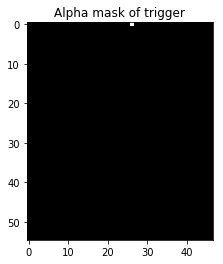

(0, 26) (1, 1, 1)
1.9999999094343048


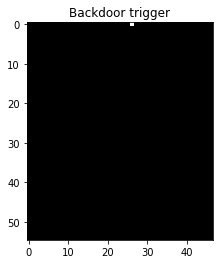

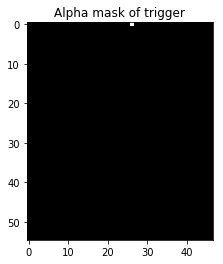

Backdoor accuracy: 0.0010124610591900312
[ 950  992  823 ... 1283 1283 1152]


In [11]:
def detect_backdoor(model, x, y):
    mask = np.zeros((55, 47, 3), dtype=np.float32)
    alpha_mask = np.zeros((55, 47, 3), dtype=np.float32)

    # Array of colors: (is_visible, color_value)
#     colors = [(False, (0, 0, 0)), (True, (0, 0, 0)), (True, (1, 1, 1)),
#               (True, (1, 0, 0)), (True, (0, 1, 0)), (True, (0, 0, 1)),
#               (True, (1, 1, 0)), (True, (0, 1, 1)), (True, (1, 0, 1))]
    colors = [(False, (0, 0, 0)), (True, (1, 1, 1))]
    mask_pix = [MaskPixel((0, 0), colors[0]) for _ in range(int(55 * 47 * 0.2))]

    dist = calc_avg_dist(model, x, mask, alpha_mask)
    print(dist)

    m_px = MaskPixel((0, 0), colors[0])
    for i in range(10000):
        idx = i % len(mask_pix)
        m_px.set_val(mask_pix[idx])
        org_dist = dist
        updated = False
        for r in range(mask.shape[0]):
            for c in range(mask.shape[1]):
                for color in colors:
                    m_px.update((r, c), color, mask, alpha_mask)
                    new_dist = calc_avg_dist(model, x, mask, alpha_mask)
                    if new_dist < dist:
                        print(new_dist)
                        updated = True
                        dist = new_dist
                        mask_pix[idx].set_val(m_px)
                
                if dist <= 1e-4:
                    break
            if dist <= 1e-4:
                break
        if dist <= 1e-4:
            break

        mask[:, :] = (0, 0, 0)
        alpha_mask[:, :] = (0, 0, 0)

        for pix in mask_pix:
            if pix.is_set:
                print(pix.pos, pix.color)
            pix.draw_mask(mask, alpha_mask)

        print(dist)
        implt(mask, t='Backdoor trigger')
        implt(alpha_mask, t='Alpha mask of trigger')
        
        if not updated:
            break
    
    full_eval(model, mask, alpha_mask)


detect_backdoor(bd_model, x_data, y_data)